## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Colab_Notebooks/UpGrad/#6 NLP Case Study - Automatic Ticket Classification/Final_Automatic Ticket Classification/complaints.json','r') # Writing the path to the data file and loading it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assigning new column names
#Removing the character "_" from the column names

for col in df.columns:
  strg = ""
  for i in range (0,len(col)):
    if col[i] == "_":
      continue
    else:
      strg += col[i]
  df.rename(columns = {col:strg}, inplace = True)

#Verifying new column names
df.columns

Index(['index', 'type', 'id', 'score', 'source.tags', 'source.zipcode',
       'source.complaintid', 'source.issue', 'source.datereceived',
       'source.state', 'source.consumerdisputed', 'source.product',
       'source.companyresponse', 'source.company', 'source.submittedvia',
       'source.datesenttocompany', 'source.companypublicresponse',
       'source.subproduct', 'source.timely', 'source.complaintwhathappened',
       'source.subissue', 'source.consumerconsentprovided'],
      dtype='object')

In [8]:
# Removing the word "Source" from the column names

for col_1 in df.columns:
  source = ""
  if len(col_1) > 6:
    for i in range (0,6):
      source += col_1[i]
  if source == "source":
    df.rename(columns = {col_1:col_1[7:]}, inplace = True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely',
       'complaintwhathappened', 'subissue', 'consumerconsentprovided'],
      dtype='object')

In [9]:
# Renaming the column "complaintwhathappened" as "complaints"

df.rename(columns = {"complaintwhathappened":"complaints"}, inplace = True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely', 'complaints',
       'subissue', 'consumerconsentprovided'],
      dtype='object')

In [10]:
#Finding the count of NaN values in all columns

df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                     0
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [11]:
#Assign nan in place of blanks in the complaints column
df["complaints"].replace(r'^\s*$', np.nan, regex=True, inplace = True)

df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                 57241
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [12]:
#Remove all rows where complaints column is nan
df.dropna(inplace = True, subset=["complaints"])

df.isna().sum()

index                          0
type                           0
id                             0
score                          0
tags                       17256
zipcode                     4645
complaintid                    0
issue                          0
datereceived                   0
state                        143
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      21070
subproduct                  2109
timely                         0
complaints                     0
subissue                    8176
consumerconsentprovided        0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    21072 non-null  object 
 1   type                     21072 non-null  object 
 2   id                       21072 non-null  object 
 3   score                    21072 non-null  float64
 4   tags                     3816 non-null   object 
 5   zipcode                  16427 non-null  object 
 6   complaintid              21072 non-null  object 
 7   issue                    21072 non-null  object 
 8   datereceived             21072 non-null  object 
 9   state                    20929 non-null  object 
 10  consumerdisputed         21072 non-null  object 
 11  product                  21072 non-null  object 
 12  companyresponse          21072 non-null  object 
 13  company                  21072 non-null  object 
 14  submittedvia          

In [14]:
#Inspecting the complaints column data

df["complaints"].head(10)

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
15                        Can you please remove inquiry
17    With out notice J.P. Morgan Chase restricted m...
20    During the summer months, I experience a decli...
21    On XXXX XX/XX/2019, I made a {$300.00} payment...
23    I have a Chase credit card which is incorrectl...
Name: complaints, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleantext(text):
  text = text.lower()                 # Making the text lowercase
  text = re.sub(r'\[|\]',"",text)     # Removing text in square brackets 
  text = re.sub(r'[^\w\s]',"",text)   # Removing punctuation
  text = re.sub(r'\w*\d\w*',"",text)  # Removing words containing numbers
  return " ".join(text.split())       # Removing unwanted empty spaces

df['complaints'] = df['complaints'].apply(lambda text: cleantext(text))

In [16]:
#Verifying the cleantext function

complaints_list = df.complaints.tolist()

# Printing few sample complaints after using the cleantext function

for i in range (0,5):
    print(complaints_list[i])
    print("\n")

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help


i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me


chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identit

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
# Writing function to Lemmatize the texts

stop_words = stopwords.words("english")

lemmatizer = WordNetLemmatizer()

def lemmatize_text(clean_text):    
    words = word_tokenize(clean_text)    # Tokenize into words    
    words = [lemmatizer.lemmatize(word, pos='n') for word in words if word not in stop_words]    
    document = " ".join(words)         # join words to make sentence    
    return document


In [19]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
lemmatized_list = [lemmatize_text(text) for text in complaints_list]

# printing few sentences from lemmatized list

lemmatized_list[:5]

['good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help',
 'upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled',
 'chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant',
 'trying book xxxx xxxx ticket came across offer applied towards ticket applied reward card put information offer within le minute notified via screen decision could made immediately contacted xxxx referred chase bank immediately contacted chase bank within getting notificat

In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame(list(zip(complaints_list, lemmatized_list)), columns =['complaints', 'lemmatized_Complaints'])

df_clean.head()

,complaints,lemmatized_Complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...


In [22]:
#Write your function to extract the POS tags 
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
def pos_tag(text):
  words = ""       
  tagged_sentence = nlp(text)    
  for token in tagged_sentence:
      if token.pos_ == "NOUN":
          words += token.text + " "     
  return words


In [23]:
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 30.5 MB/s 
     |████████████████████████████████| 281 kB 68.3 MB/s 
     |████████████████████████████████| 1.6 MB 61.7 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=267dc41521964d13ed785a596c0703fa5a0f75e42c1cee795bee2331758cf4db
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [24]:
import swifter

In [25]:
df_clean["complaint_POS_removed"] =  df_clean['lemmatized_Complaints'].swifter.apply(pos_tag) #this column contains lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...
...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




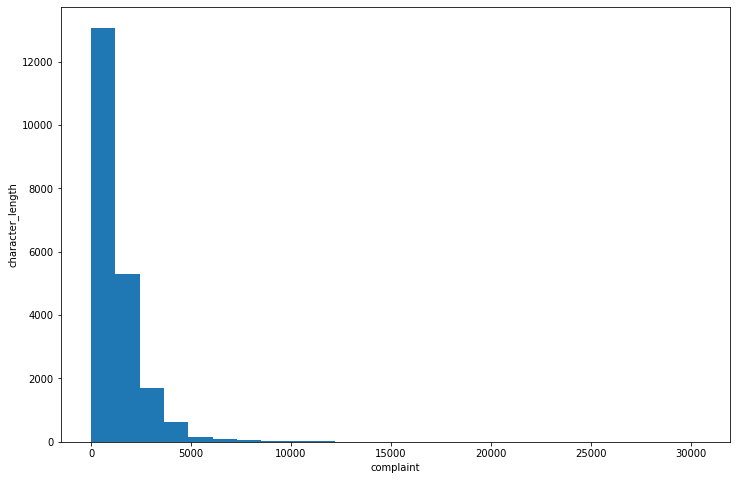

In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(12,8))
char_len = [len(char) for char in df_clean.complaints]
plt.hist(char_len, bins = 25)
plt.xlabel('complaint')
plt.ylabel('character_length');

#### Find the top 40 words by frequency among all the articles after processing the text.

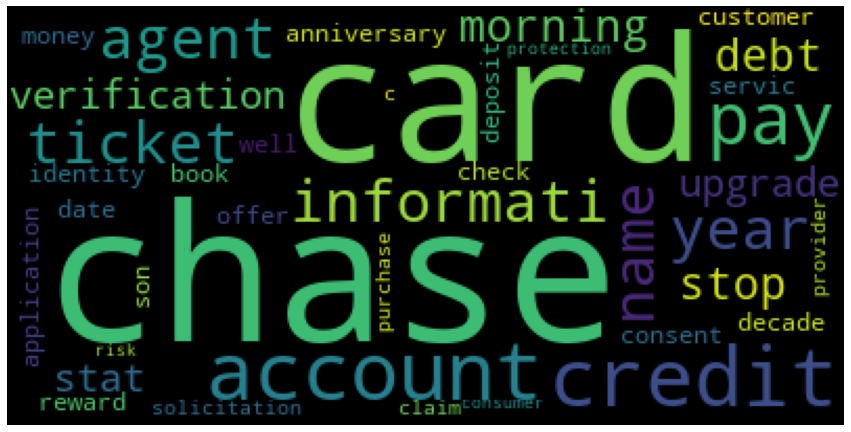

In [28]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaint_POS_removed))
plt.figure(figsize=(15,9))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [29]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [30]:
#Code to find the top unigram frequency among the complaints in the cleaned datafram(df_clean). 

def freq_word_unigrams(text, n=None):
    vec = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [31]:
#Printing the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
frequent_words = freq_word_unigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
print(frequent_words)

[('chase', 59476), ('account', 42390), ('credit', 31732), ('card', 29360), ('payment', 20598), ('time', 15501), ('bank', 13795), ('charge', 12449), ('day', 12116), ('money', 11828), ('loan', 10270), ('information', 9514), ('check', 9465), ('letter', 9055), ('fee', 8724), ('number', 8557), ('month', 8121), ('transaction', 7987), ('customer', 7907), ('year', 7854), ('mortgage', 7511), ('balance', 7479), ('phone', 7405), ('report', 7193), ('company', 7157), ('service', 7058), ('claim', 6822), ('fund', 6052), ('email', 5779), ('fraud', 5704)]


In [32]:
#Print the top 10 words in the unigram frequency
freq_unigram = pd.DataFrame(frequent_words, columns = ['unigram' , 'count'])
freq_unigram.head(10)

,unigram,count
0,chase,59476
1,account,42390
2,credit,31732
3,card,29360
4,payment,20598
5,time,15501
6,bank,13795
7,charge,12449
8,day,12116
9,money,11828


In [33]:
#Code to find the top biigram frequency among the complaints in the cleaned datafram(df_clean). 


def freq_word_bigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [34]:
#Printing the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
freq_words_bi = freq_word_bigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
print(freq_words_bi)

[('credit card', 12239), ('credit report', 3624), ('account chase', 3398), ('chase credit', 3393), ('customer service', 2787), ('chase account', 2662), ('chase bank', 2619), ('account account', 2497), ('card chase', 2121), ('checking account', 1994), ('debit card', 1934), ('card account', 1765), ('chase card', 1723), ('credit score', 1666), ('payment payment', 1594), ('chase chase', 1545), ('account credit', 1489), ('money account', 1424), ('payment chase', 1412), ('bank account', 1395), ('letter chase', 1388), ('chase customer', 1286), ('phone number', 1264), ('card card', 1137), ('card company', 1135), ('account number', 1131), ('charge chase', 1125), ('business day', 1121), ('card credit', 1086), ('chase payment', 1070)]


In [35]:
#Print the top 10 words in the bigram frequency

freq_bigram = pd.DataFrame(freq_words_bi, columns = ['bigram' , 'count'])
freq_bigram.head(10)

,bigram,count
0,credit card,12239
1,credit report,3624
2,account chase,3398
3,chase credit,3393
4,customer service,2787
5,chase account,2662
6,chase bank,2619
7,account account,2497
8,card chase,2121
9,checking account,1994


In [36]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

def freq_word_trigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [37]:
#Print the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean)

freq_words_tri = freq_word_trigrams(df_clean['Complaint_clean'].values.astype('U'), 30)
print(freq_words_tri)


[('chase credit card', 2291), ('credit card account', 1068), ('credit card company', 970), ('credit card chase', 963), ('chase customer service', 574), ('credit card credit', 538), ('inquiry credit report', 506), ('card credit card', 410), ('account credit card', 406), ('charge credit card', 394), ('chase checking account', 391), ('credit report credit', 342), ('credit card payment', 332), ('account chase account', 312), ('account credit report', 310), ('customer service representative', 302), ('credit reporting act', 298), ('credit card charge', 273), ('chase auto finance', 272), ('credit card balance', 269), ('credit card card', 258), ('credit report chase', 255), ('chase card service', 254), ('credit reporting agency', 254), ('chase account chase', 236), ('payment credit card', 233), ('victim identity theft', 228), ('freedom credit card', 227), ('credit card service', 225), ('credit card statement', 205)]


In [38]:
#Print the top 10 words in the trigram frequency

freq_trigram = pd.DataFrame(freq_words_tri, columns = ['trigram' , 'count'])
freq_trigram.head(10)

,trigram,count
0,chase credit card,2291
1,credit card account,1068
2,credit card company,970
3,credit card chase,963
4,chase customer service,574
5,credit card credit,538
6,inquiry credit report,506
7,card credit card,410
8,account credit card,406
9,charge credit card,394


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [39]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [40]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...,chase card customer well decade solicitation c...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...,pay risk consumer year trust banking deal merc...
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [41]:
#Write your code here to initialise the TfidfVectorizer 

tfidfVect = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_dtm = tfidfVect.fit_transform(df_clean['Complaint_clean'])

In [43]:
tfidf_tokens = tfidfVect.get_feature_names()

# print 10 tokens randomly to verify
import random
random.sample(tfidf_tokens, 10)

['sabotage',
 'contacted',
 'inconvenience',
 'commitment',
 'friend',
 'antedates',
 'announcement',
 'committee',
 'epicenter',
 'ingenuity']

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [44]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [45]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40

nmf_model = NMF(n_components=num_topics, random_state=40)

In [46]:
nmf_model.fit(tfidf_dtm)
len(tfidfVect.get_feature_names())

6400

In [47]:
#Document-topic matrix & Topic-term matrix

W = nmf_model.fit_transform(tfidf_dtm) # Document-topic matrix
H = nmf_model.components_ # Topic-term matrix

In [48]:
#Print the Top15 words for each of the topics
words = np.array(tfidfVect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i+1}' for i in range(num_topics)], columns=[f'Word {i+1}' for i in range(15)]).astype(str)

for i in range(num_topics):
  ix = H[i].argsort()[::-1][:15]
  topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,chase,bank,fund,deposit,day,branch,transaction,checking,number,business,claim,fee
Topic 2,card,charge,chase,credit,dispute,purchase,transaction,fee,service,merchant,fraud,time,balance,company,customer
Topic 3,payment,balance,fee,month,statement,day,chase,date,time,pay,auto,credit,error,year,mortgage
Topic 4,credit,report,inquiry,card,account,score,debt,company,bureau,reporting,information,identity,application,limit,theft
Topic 5,loan,mortgage,chase,modification,home,property,year,letter,document,rate,time,foreclosure,sale,information,debt


In [49]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

doc_topic = pd.DataFrame(W, columns = [f'Topic {i + 1}' for i in range(num_topics)])
doc_topic["Best_Topic"] = doc_topic.apply(lambda x : np.argmax(x), axis = 1)
doc_topic.head()


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Best_Topic
0,0.020872,0.004850,0.008684,0.015800,0.027183,4
1,0.010449,0.001468,0.000934,0.003215,0.004212,0
2,0.000025,0.026918,0.000000,0.031247,0.003522,3
3,0.015989,0.021798,0.000086,0.048445,0.019407,3
4,0.061069,0.000849,0.000000,0.000000,0.006378,0


In [50]:
#Assign the best topic to each of the complaints in Topic Column

df_clean['Topic'] = doc_topic["Best_Topic"]

In [51]:
df_clean.head()

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...,4
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,3
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,0


In [52]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
12,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account code term account deposit bonus day de...,account code term account deposit bonus day de...,0
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,0
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
10,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto,account chase auto,0
21,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,citizen company time share company refund cred...,citizen company time share company refund cred...,1
19,i made a purchase with xxxx xxxx xxxx on in th...,made purchase xxxx xxxx xxxx amount charged tw...,purchase amount transaction dispute case charg...,purchase amount transaction dispute case charg...,1
8,on xxxx i made a payment to an online retailer...,xxxx made payment online retailer using chase ...,payment retailer chase pay website scam websit...,payment retailer chase pay website scam websit...,1
16,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,love seat table chair debit card bank claim fu...,love seat table chair debit card bank claim fu...,1
14,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,amazon card catering order brother funeral amo...,amazon card catering order brother funeral amo...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [53]:
#Create the dictionary of Topic names and Topics

Topic_names = {0 : "Bank Account services", 1 : "Credit card/Prepaid card", 2 : "Mortgage/Loan", 3 : "Others", 4 : "Theft/Dispute Reporting"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [54]:
df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...,Theft/Dispute Reporting
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,Bank Account services
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,Others
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,Others
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,Bank Account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...,chase card customer well decade solicitation c...,Credit card/Prepaid card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Credit card/Prepaid card
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...,pay risk consumer year trust banking deal merc...,Others
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [55]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card/Prepaid card":1,
               "Mortgage/Loan":2,
               "Others":3,
               "Theft/Dispute Reporting":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [56]:
df_clean

,complaints,lemmatized_Complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop chase debt verification stat...,morning name stop chase debt verification stat...,4
1,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent upgrade ann...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
2,chase card was reported on however fraudulent ...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,3
3,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,3
4,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...,0
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade solicitation c...,chase card customer well decade solicitation c...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,1
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer year trust banking deal merc...,pay risk consumer year trust banking deal merc...,3
21070,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,2


In [57]:
#Keep the columns "complaints" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaints","Topic"]]

In [58]:
training_data

,complaints,Topic
0,good morning my name is xxxx xxxx and i apprec...,4
1,i upgraded my xxxx xxxx card in and was told b...,0
2,chase card was reported on however fraudulent ...,3
3,on while trying to book a xxxx xxxx ticket i c...,3
4,my grand son give me check for i deposit it in...,0
...,...,...
21067,after being a chase card customer for well ove...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,1
21069,i am not familiar with xxxx pay and did not un...,3
21070,i have had flawless credit for yrs ive had cha...,2


In [59]:
#Checking the training data

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   complaints  21072 non-null  object
 1   Topic       21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:
# Carrying out required Imports

import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


In [61]:
#Train-Test split

X_train_complaint, X_test_complaint, y_train, y_test = train_test_split(training_data.complaints, training_data.Topic , train_size=0.8, random_state=40)

In [62]:
#Code to get the Vector count

count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_complaint)
X_test = count_vect.transform(X_test_complaint)

#Code to transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [63]:
# Shape after split

print("X_train.shape: ",X_train.shape,";","y_train.shape: ",y_train.shape)
print("X_test.shape: ",X_test.shape,";","y_test.shape: ",y_test.shape)

X_train.shape:  (16857, 30069) ; y_train.shape:  (16857,)
X_test.shape:  (4215, 30069) ; y_test.shape:  (4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

###### Write your code here to build any 3 models and evaluate them using the required metrics

In [64]:
# Carrying out required Imports

from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics

In [65]:
#Logistic Regression

logreg = LogisticRegression(random_state = 42, max_iter=400)
logreg.fit(X_train, y_train)

y_test_pred = logreg.predict(X_test)
f1 = f1_score(y_test, y_test_pred, average="weighted")
accuracy = metrics.accuracy_score(y_test, y_test_pred)

print("Logistic Regression_f1_score: ",f1,";","Logistic Regression_accuracy: ",accuracy)

Logistic Regression_f1_score:  0.9182957401217058 ; Logistic Regression_accuracy:  0.9186239620403321


#Logistic Regression_f1_score:  0.92
#Logistic Regression_accuracy:  0.92

In [66]:
# Decision Tree

dt = DecisionTreeClassifier(max_depth=8, random_state=40)
dt.fit(X_train, y_train)

y_test_pred = dt.predict(X_test)
f1 = f1_score(y_test, y_test_pred, average="weighted")
accuracy = metrics.accuracy_score(y_test, y_test_pred)

print("Decision Tree_f1_score: ",f1,";","Decision Tree_accuracy: ",accuracy)

Decision Tree_f1_score:  0.7699384113061573 ; Decision Tree_accuracy:  0.7710557532621589


#Decision Tree_f1_score:  0.77
#Decision Tree_accuracy:  0.77

In [67]:
#Random Forest

rf = RandomForestClassifier(random_state=40)
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_test_pred, average="weighted")
accuracy = metrics.accuracy_score(y_test, y_test_pred)

print("Random Forest_f1_score: ",f1,";","Random Forest_accuracy: ",accuracy)

Random Forest_f1_score:  0.8081616719116504 ; Random Forest_accuracy:  0.8149466192170819


#Random Forest_f1_score:  0.81
#Random Forest_accuracy:  0.81

#Inference:
###Logistic Regression proves to be the best model with f1_score - 0.92 & accuracy - 0.92.

In [68]:
# Using a custom text to verify the Logisitc regression model prediction.

custom_text = "after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me\n\nchase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for xxxx enrollment and failed to credit airline charge as agreed upon"

In [69]:
#Code to get the Vector count
custom_text_cnt = count_vect.transform([custom_text])

#Code to transform the word vector to tf-idf
custom_text_tfidf = tfidf_transformer.transform(custom_text_cnt)

In [70]:
# Predicting the topic using logistic regression

y_custom_pred = logreg.predict(custom_text_tfidf)

In [71]:
#Predicted Label

print(y_custom_pred)

[1]


#Custom text Inference:

#####-----------------------------------
###Topic Lables
#####'Bank account services' : 0,
#####'Credit card or Prepaid card' : 1
#####'Theft or Dispute reporting' : 2,
#####'Mortgages or loans' : 3,
#####'Others' : 4
#####-----------------------------------
###Predicted Label is '1' that corresponds to 'Credit card or Prepaid card'.
#####Therefore the custom text will be classified as 'Credit card or Prepaid card' by the preferred logistic regression model.